In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import splitfolders

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2823782852962170508,
 name: "/device:GPU:0"
 device_type: "GPU"
 locality {
   bus_id: 1
 }
 incarnation: 16824638581818881479
 physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"]

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [7]:
# split into training and validation set, and training set.
splitfolders.ratio("training", output="dataset", seed=seed, ratio=(.8, .1, .1), group_prefix=None) # default values

In [51]:
%cd /Users/irfanmasudi/ANNDL/Challange/

/Users/irfanmasudi/ANNDL/Challange


In [54]:
# Dataset folders 
dataset_dir = 'dataset'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

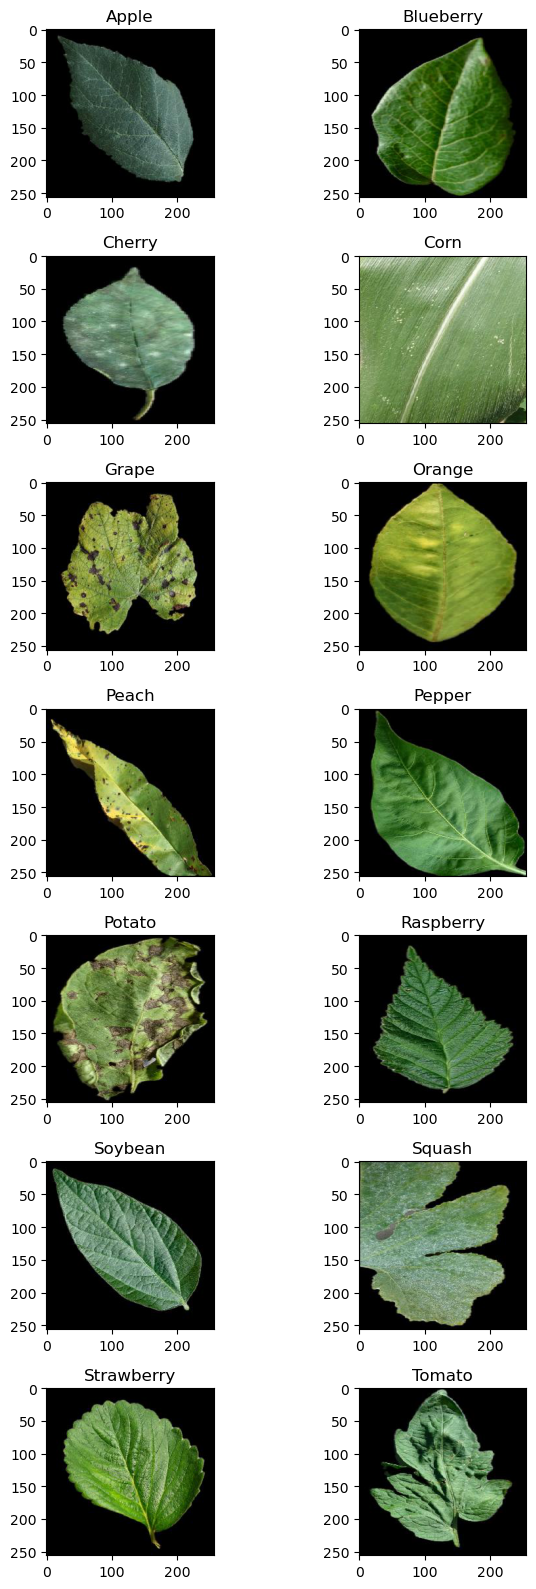

In [55]:
# Plot example images from dataset
labels = ['Apple',       # 0
          'Blueberry',   # 1
          'Cherry',      # 2
          'Corn',        # 3
          'Grape',       # 4
          'Orange',      # 5
          'Peach',       # 6
          'Pepper',      # 7
          'Potato',      # 8
          'Raspberry',   # 9
          'Soybean',     # 10
          'Squash',      # 11
          'Strawberry',  # 12
          'Tomato']      # 13

num_row = 7
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(num_row,8*num_col))
for i in range(num_row*num_col):
    if i < 14:
        class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [56]:
# Inspect dataset structure on disk
print("Depth 0 (dataset")
print("-------")
!ls dataset
print()
print("Depth 1 (e.g., dataset/train)")
print("------------------------")
!ls dataset/train
print()
print("Depth 2 (e.g., dataset/train/Corn)")
print("----------------------------")
!ls dataset/train/Corn

Depth 0 (dataset
-------
test  train val

Depth 1 (e.g., dataset/train)
------------------------
Apple      Cherry     Grape      Peach      Potato     Soybean    Strawberry
Blueberry  Corn       Orange     Pepper     Raspberry  Squash     Tomato

Depth 2 (e.g., dataset/train/Corn)
----------------------------
04002.jpg 04195.jpg 04386.jpg 25134.jpg 25325.jpg 25514.jpg 25691.jpg 25874.jpg
04004.jpg 04196.jpg 04387.jpg 25135.jpg 25327.jpg 25516.jpg 25692.jpg 25875.jpg
04005.jpg 04197.jpg 04388.jpg 25136.jpg 25328.jpg 25517.jpg 25693.jpg 25876.jpg
04006.jpg 04198.jpg 04389.jpg 25137.jpg 25329.jpg 25518.jpg 25694.jpg 25877.jpg
04007.jpg 04200.jpg 04390.jpg 25138.jpg 25331.jpg 25519.jpg 25696.jpg 25878.jpg
04009.jpg 04204.jpg 04391.jpg 25141.jpg 25332.jpg 25520.jpg 25698.jpg 25879.jpg
04010.jpg 04209.jpg 04393.jpg 25144.jpg 25333.jpg 25523.jpg 25699.jpg 25880.jpg
04011.jpg 04210.jpg 04394.jpg 25146.jpg 25334.jpg 25524.jpg 25700.jpg 25881.jpg
04012.jpg 04211.jpg 04395.jpg 25149.jpg 25335.jp

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels ['aiplane' -> read from the directory]
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True, #during the training per epoch it will shuffle
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False, #shuffle is not important for the training and test
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 14176 images belonging to 14 classes.
Found 1765 images belonging to 14 classes.
Found 1787 images belonging to 14 classes.


In [28]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


In [31]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))
    plt.show()
    
    return batch

(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 14)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Label: 13
Class name: Tomato


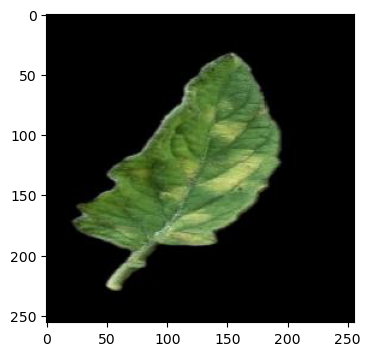

In [32]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

Rotation: {'theta': -7.527592869158251, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': 38, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.9247240713084175, 'zy': 1.2704285838459497, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



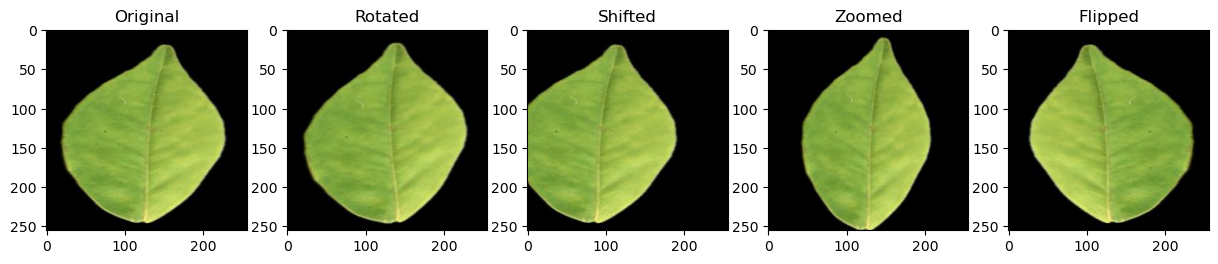

In [33]:
# Create some augmentation examples

# Get sample image
image = next(train_gen)[0][4] 

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=50)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Flip:', flip_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='constant', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t) 
zoomed = gen.apply_transform(image, zoom_t) 
flipped = gen.apply_transform(image, flip_t)  

# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')
plt.show()

Transform: {'theta': -7.527592869158251, 'tx': -28, 'ty': 42, 'shear': 0, 'zx': 1.059195090518222, 'zy': 0.7936111842654618, 'flip_horizontal': 1, 'flip_vertical': 1, 'channel_shift_intensity': None, 'brightness': None}


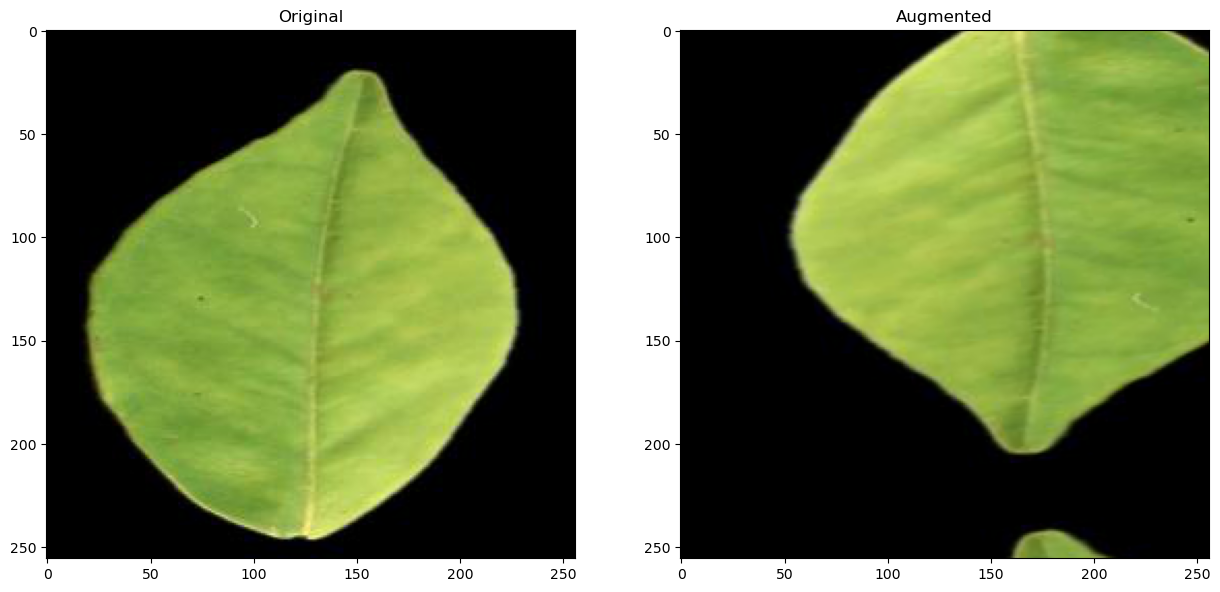

In [34]:
# Combine multiple transformations
gen = ImageDataGenerator(rotation_range=30,
                         height_shift_range=50,
                         width_shift_range=50,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True, 
                         fill_mode='reflect')

# Get random transformation
t = gen.get_random_transform(img_shape=(256, 256), seed=seed)
print("Transform:", t)

# Apply the transformation
augmented = gen.apply_transform(image, t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Augmented")
plt.show()

In [35]:
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=8,
                                             shuffle=False,
                                             seed=seed)

Found 14176 images belonging to 14 classes.
Found 1765 images belonging to 14 classes.
Found 1787 images belonging to 14 classes.


In [36]:
input_shape = (256, 256, 3)
epochs = 200

In [37]:
# Model used for the exercise:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [38]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('data_augmentation')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

  # Model checkpoint
  # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

  # Early Stopping
  # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

    return callbacks

In [39]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0     

In [40]:
tf.get_logger().setLevel('WARNING') #  if you want to suppress only INFOs
# tf.get_logger().setLevel('ERROR') #  if you want to suppress both WARNINGs and INFOs

# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
1772/1772 [==============================] - 111s 62ms/step - loss: 1.7295 - accuracy: 0.4421 - val_loss: 1.1149 - val_accuracy: 0.6300


Epoch 2/200
1772/1772 [==============================] - 110s 62ms/step - loss: 1.2122 - accuracy: 0.6088 - val_loss: 0.8016 - val_accuracy: 0.7275


Epoch 3/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.9725 - accuracy: 0.6812 - val_loss: 0.7005 - val_accuracy: 0.7660


Epoch 4/200
1772/1772 [==============================] - 106s 60ms/step - loss: 0.8655 - accuracy: 0.7230 - val_loss: 0.6003 - val_accuracy: 0.8034


Epoch 5/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.7673 - accuracy: 0.7511 - val_loss: 0.5235 - val_accuracy: 0.8170


Epoch 6/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.6656 - accuracy: 0.7848 - val_loss: 0.5629 - val_accuracy: 0.8170


Epoch 7/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.6185 - accuracy: 0.8005 - val_loss: 0.4319 - val_accuracy: 0.8476


Epoch 8/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.5636 - accuracy: 0.8163 - val_loss: 0.4204 - val_accuracy: 0.8612


Epoch 9/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.5149 - accuracy: 0.8346 - val_loss: 0.3481 - val_accuracy: 0.8929


Epoch 10/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.4894 - accuracy: 0.8410 - val_loss: 0.2638 - val_accuracy: 0.9127


Epoch 11/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.4647 - accuracy: 0.8533 - val_loss: 0.3881 - val_accuracy: 0.8788


Epoch 12/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.4585 - accuracy: 0.8546 - val_loss: 0.4081 - val_accuracy: 0.8720


Epoch 13/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.4211 - accuracy: 0.8672 - val_loss: 0.2790 - val_accuracy: 0.9065


Epoch 14/200
1772/1772 [==============================] - 111s 63ms/step - loss: 0.4073 - accuracy: 0.8729 - val_loss: 0.3153 - val_accuracy: 0.8986


Epoch 15/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.4000 - accuracy: 0.8745 - val_loss: 0.2691 - val_accuracy: 0.9122


Epoch 16/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.4048 - accuracy: 0.8729 - val_loss: 0.1614 - val_accuracy: 0.9462


Epoch 17/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.3788 - accuracy: 0.8787 - val_loss: 0.2960 - val_accuracy: 0.9054


Epoch 18/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.3694 - accuracy: 0.8864 - val_loss: 0.1674 - val_accuracy: 0.9416


Epoch 19/200
1772/1772 [==============================] - 118s 67ms/step - loss: 0.3671 - accuracy: 0.8861 - val_loss: 0.3068 - val_accuracy: 0.9105


Epoch 20/200
1772/1772 [==============================] - 109s 61ms/step - loss: 0.3520 - accuracy: 0.8918 - val_loss: 0.2326 - val_accuracy: 0.9224


Epoch 21/200
1772/1772 [==============================] - 109s 62ms/step - loss: 0.3704 - accuracy: 0.8867 - val_loss: 0.2433 - val_accuracy: 0.9071


Epoch 22/200
1772/1772 [==============================] - 109s 61ms/step - loss: 0.3432 - accuracy: 0.8940 - val_loss: 0.1639 - val_accuracy: 0.9411


Epoch 23/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.3443 - accuracy: 0.8943 - val_loss: 0.1951 - val_accuracy: 0.9343


Epoch 24/200
1772/1772 [==============================] - 106s 60ms/step - loss: 0.3400 - accuracy: 0.8981 - val_loss: 0.2584 - val_accuracy: 0.9235


Epoch 25/200
1772/1772 [==============================] - 107s 61ms/step - loss: 0.3530 - accuracy: 0.8928 - val_loss: 0.1545 - val_accuracy: 0.9535


Epoch 26/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.3224 - accuracy: 0.9003 - val_loss: 0.2869 - val_accuracy: 0.9082


Epoch 27/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.3463 - accuracy: 0.8937 - val_loss: 0.2196 - val_accuracy: 0.9303


Epoch 28/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.3255 - accuracy: 0.9007 - val_loss: 0.2464 - val_accuracy: 0.9178


Epoch 29/200
1772/1772 [==============================] - 106s 60ms/step - loss: 0.3409 - accuracy: 0.8964 - val_loss: 0.1565 - val_accuracy: 0.9501


Epoch 30/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.3313 - accuracy: 0.8987 - val_loss: 0.1145 - val_accuracy: 0.9620


Epoch 31/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.3314 - accuracy: 0.9006 - val_loss: 0.1446 - val_accuracy: 0.9530


Epoch 32/200
1772/1772 [==============================] - 106s 60ms/step - loss: 0.3234 - accuracy: 0.9034 - val_loss: 0.2243 - val_accuracy: 0.9320


Epoch 33/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.3149 - accuracy: 0.9055 - val_loss: 0.1768 - val_accuracy: 0.9445


Epoch 34/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.3128 - accuracy: 0.9084 - val_loss: 0.1221 - val_accuracy: 0.9615


Epoch 35/200
1772/1772 [==============================] - 108s 61ms/step - loss: 0.3291 - accuracy: 0.9033 - val_loss: 0.2519 - val_accuracy: 0.9099


Epoch 36/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.3278 - accuracy: 0.9012 - val_loss: 0.2117 - val_accuracy: 0.9292


Epoch 37/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.3141 - accuracy: 0.9060 - val_loss: 0.1292 - val_accuracy: 0.9632


Epoch 38/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.3359 - accuracy: 0.9022 - val_loss: 0.2903 - val_accuracy: 0.9184


Epoch 39/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.3201 - accuracy: 0.9060 - val_loss: 0.2989 - val_accuracy: 0.9065


Epoch 40/200
1772/1772 [==============================] - 107s 60ms/step - loss: 0.3102 - accuracy: 0.9082 - val_loss: 0.1324 - val_accuracy: 0.9552


In [41]:
# Save best epoch model
model.save("data_augmentation/CNN_Aug_Best")

In [42]:
model_aug = tfk.models.load_model("data_augmentation/CNN_Aug_Best")
model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics with data augmentation")
print(model_aug_test_metrics)

224/224 [==============================] - 4s 15ms/step - loss: 0.1620 - accuracy: 0.9591

Test metrics with data augmentation
{'loss': 0.1619507074356079, 'accuracy': 0.9591494202613831}


In [48]:
# Predict the test set with the CNN
predictions = model_aug.predict(test_gen)
predictions.shape

(1787, 14)

In [49]:
# Plot the target images and the predictions
prediction_index = 99

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(test_gen[prediction_index])

ValueError: could not broadcast input array from shape (8,256,256,3) into shape (8)